In [356]:
import numpy as np
import math
import os
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.externals import joblib

Random Forest Models built from various subcategories of ~150,000 shape dataset compiled using the Midway supercomputer from the Research Computing Center at UChicago. These subcategories are located within the "./rcc_shapes/" folder. Information about these subcategories is displayed in this table: 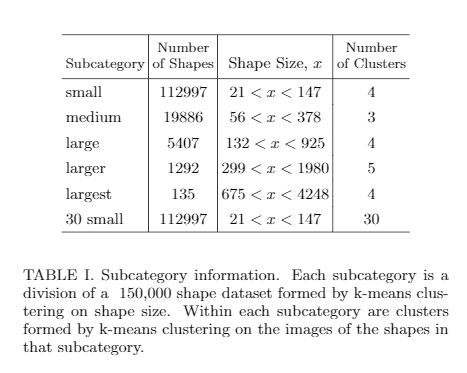

In [270]:
def read_images(label):
    '''
    Takes a subcategory name and returns images and labels from that subcategory
    '''
    
    dir_name = "./rcc_shapes/"
    #change dir_name to contain name of directory where labeled images are located.
    
    cluster_dir = os.listdir(dir_name + label)
    exception = "n/a"
    for i, clust in enumerate(cluster_dir):
        try: 
            int(clust)
        except:
            exception = i
    cluster_dir = [clust for i, clust in enumerate(cluster_dir) if i != exception]
    X, y = [], []
    for clust in cluster_dir:
        img_list = os.listdir(dir_name + label + "/{}/".format(clust))
        for loc in img_list:
            img = cv2.imread(dir_name + label + "/{}/".format(clust) + loc, -1)
            X.append(img)
            y.append(int(clust))
    return X, y

In [352]:
small30_x, small30_y = read_images("30_small_labels")

In [271]:
small_x, small_y = read_images("small_labels")

In [261]:
med_x, med_y = read_images("med_labels")
large_x, large_y = read_images("large_labels")
larger_x, larger_y = read_images("larger_labels")
largest_x, largest_y = read_images("largest_labels")

In [358]:
def process_img(X, y):
    '''
    Takes images(X) and their respective labels(y) and randomizes their arrangement, and
    flattens and pads images to be of same length. 
    '''
    X1 = np.copy(X)
    y1 = np.copy(y)
    random.Random(4).shuffle(X1)
    random.Random(4).shuffle(y1)
    X1 = [image.flatten() for image in X1]
    maxl = 0
    for img in X1:
        if len(img) > maxl:
            maxl = len(img)     
    padX = []
    for img in X1:
        padl = maxl - len(img)
        imgpad = np.pad(img.flatten(), (0, padl), 'constant', constant_values=(255))
        padX.append(cv2.bitwise_not(imgpad))
    X1 = np.array(padX)
    X1 = X1.reshape(X1.shape[0], X1.shape[1])
    return X1, y1

In [359]:
proc_small_X, proc_small_y = process_img(small_x, small_y)

In [360]:
proc_small30_X, proc_small30_y = process_img(small30_x, small30_y)

In [362]:
proc_med_X, proc_med_y = process_img(med_x, med_y)
proc_large_X, proc_large_y = process_img(large_x, large_y)
proc_larger_X, proc_larger_y = process_img(larger_x, larger_y)
proc_largest_X, proc_largest_y = process_img(largest_x, largest_y)

In [259]:
def build_model(X, y):
    '''
    Takes processed images(X) and their respective labels(y) 
    and trains and tests a random forest model 
    '''
    split = int(.8 * len(X))
    subX = X[:split]
    suby = y[:split]
    validX = X[split:]
    validy = y[split:]
    high_score = 0
    score_l = []
    for rs in np.arange(5):
        X_train, X_test, y_train, y_test = train_test_split(subX, suby, test_size=0.20, random_state=rs)
        clf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=30)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        if score > high_score:
            high_score = score
            best_model = clf
        score_l.append(score)
    print("train score:", np.average(score_l))
    print("valid score:", best_model.score(validX, validy))
    return best_model

In [274]:
print("small")
small_model = build_model(proc_small_X, proc_small_y)
print("-----------------------------------------")

small
train score: 0.987654867256637
valid score: 0.9879203539823009
-----------------------------------------


In [354]:
print("30 small")
small30_model = build_model(proc_small30_X, proc_small30_y)

30 small
train score: 0.9836788837574924
valid score: 0.9824313170616673


In [263]:
print("med")
large_model = build_model(proc_med_X, proc_med_y)
print("-----------------------------------------")
print("large")
large_model = build_model(proc_large_X, proc_large_y)
print("-----------------------------------------")
print("larger")
larger_model = build_model(proc_larger_X, proc_larger_y)
print("-----------------------------------------")
print("largest")
largest_model = build_model(proc_largest_X, proc_largest_y)
print("-----------------------------------------")

med
train score: 0.9357008170961659
valid score: 0.9424333836098542
-----------------------------------------
large
train score: 0.8076300578034683
valid score: 0.8096118299445472
-----------------------------------------
larger
train score: 0.7014492753623188
valid score: 0.6254826254826255
-----------------------------------------
largest
train score: 0.5909090909090909
valid score: 0.6296296296296297
-----------------------------------------


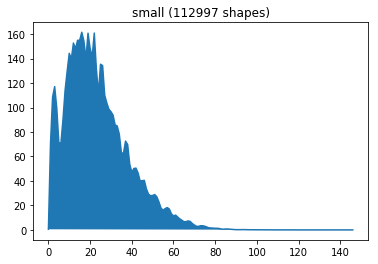

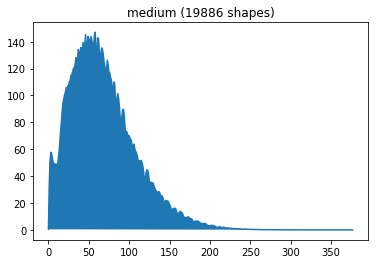

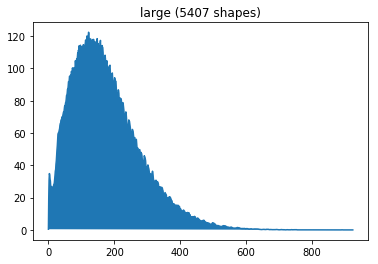

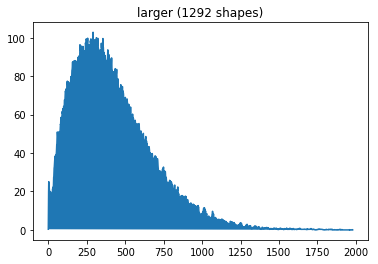

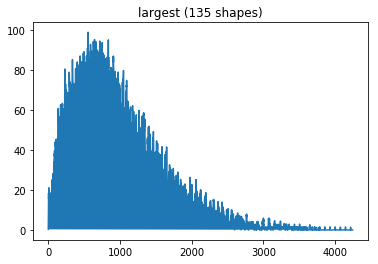

In [330]:
#Some subcategory analysis
for label, proc_x in [("small", proc_small_X), ("medium", proc_med_X), ("large", proc_large_X), ("larger", proc_larger_X), ("largest", proc_largest_X)]:
    dist = [np.sum(i) / len(proc_x) for i in np.transpose(proc_x)]
    plt.figure()
    plt.plot(dist)
    plt.fill(dist)
    plt.title("{} ({} shapes)".format(label, proc_x.shape[0]))
    plt.savefig('./report_images/average_flat_shapes_{}'.format(label))
    plt.show()

In [323]:
def concat_x(shape_set):
    '''
    Combines images from shape_set = [subcategory1, subcategory2, ...]
    '''
    concat_imgs = []
    for imgs in shape_set:
        for img in imgs:
            concat_imgs.append(img)
    return concat_imgs

def concat_y(y_set, distinct_labels):
    '''
    Combines labels from yset = [labels1, labels2, ...]
    Distinct_labels == True preserves the clusters within each labels in yset
    '''
    concaten_y = []
    num_labels = 0
    for j, labels in enumerate(y_set):
        for y in labels:
            if distinct_labels == True:
                newy = y + num_labels
            else:
                newy = j
            concaten_y.append(newy)
        num_labels += len(set(labels))
    return concaten_y

def concat_xy(x, y, distinct_labels):
    '''
    Combines images(X) and labels(y) 
    '''
    newx = concat_x(x)
    newy = concat_y(y, distinct_labels)
    return newx, newy

In [331]:
large_set = [large_x, larger_x, largest_x]
large_y = [large_y, larger_y, largest_y]
newlarge_x, newlarge_y = concat_xy(large_set, large_y, False)
dnewlarge_x, dnewlarge_y = concat_xy(large_set, large_y, True)

In [332]:
proc_newlarge_x, proc_newlarge_y = process_img(newlarge_x, newlarge_y)
newlarge_model = build_model(proc_newlarge_x, proc_newlarge_y)

[253 255 254 254 117 102  87  85 255 255 255 255 253 255 253]
[  2   0   1   1 138 153 168 170   0   0   0   0   2   0   2]
train score: 0.9363802559414991
valid score: 0.9239209948792977


In [333]:
proc_dnewlarge_x, proc_dnewlarge_y = process_img(dnewlarge_x, dnewlarge_y)
dnewlarge_model = build_model(proc_dnewlarge_x, proc_dnewlarge_y)

[253 255 254 254 117 102  87  85 255 255 255 255 253 255 253]
[  2   0   1   1 138 153 168 170   0   0   0   0   2   0   2]
train score: 0.7206581352833639
valid score: 0.709583028529627


In [336]:
total_set = [small_x, med_x, newlarge_x]
total_label = [small_y, med_y, newlarge_y]
total_x, total_y = concat_xy(total_set, total_label, False)
dtotal_x, dtotal_y = concat_xy(total_set, total_label, True)

In [337]:
proc_total_x, proc_total_y = process_img(total_x, total_y)
total_model = build_model(proc_total_x, proc_total_y)

[255 255  78  84  78  75  73  76  84 255 252  81  68  53  49]
[  0   0 177 171 177 180 182 179 171   0   3 174 187 202 206]
train score: 0.9752896443748602
valid score: 0.9752719725164615


In [351]:
proc_dtotal_x, proc_dtotal_y = process_img(dtotal_x, dtotal_y)
dtotal_model = build_model(proc_dtotal_x, proc_dtotal_y)

[255 255  78  84  78  75  73  76  84 255 252  81  68  53  49]
[  0   0 177 171 177 180 182 179 171   0   3 174 187 202 206]
train score: 0.9498814582867368
valid score: 0.9499355854566276


In [357]:
filename = 'shape_classification_model.sav'
joblib.dump(dtotal_model, filename)

['shape_classification_model.sav']